In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
from tqdm import tqdm
import time
import cv2
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
!pip install self_attention_cv
from self_attention_cv.bottleneck_transformer import BottleneckBlock

import torchvision
#from torchvision.datasets import MNIST

     |████████████████████████████████| 286kB 15.5MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: pluggy 0.7.1
    Uninstalling pluggy-0.7.1:
      Successfully uninstalled pluggy-0.7.1
  Found existing installation: pytest 3.6.4
    Uninstalling pytest-3.6.4:
      Successfully uninstalled pytest-3.6.4


In [ ]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        # print(kwargs["input_shape"])
        # self.encoder_hidden_layer = nn.Linear(
        #     in_features=kwargs["input_shape"], out_features=128
        # )
        # self.encoder_output_layer = nn.Linear(
        #     in_features=128, out_features=128
        # )
        # self.decoder_hidden_layer = nn.Linear(
        #     in_features=128, out_features=128
        # )
        # self.decoder_output_layer = nn.Linear(
        #     in_features=128, out_features=kwargs["input_shape"]
        # )

        # ENCODING

        # block 2 up
        self.en_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, 
                      kernel_size=3,stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, 
                      kernel_size=3,padding=1,stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, 
                      kernel_size=3,padding=1,stride=2),
            nn.ReLU(inplace=True)
        )

        # self attention block 1
        self.attention1 = BottleneckBlock(in_channels=32, fmap_size=(32, 32), heads=4, out_channels=32, pooling=True)

        self.en_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, 
                      kernel_size=3,padding=1,stride=2),
            nn.ReLU(inplace=True)
        )

        # self attention block 2
        self.attention2 = BottleneckBlock(in_channels=16, fmap_size=(16, 16), heads=4, out_channels=16, pooling=True)


        self.en_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, 
                      kernel_size=3,padding=1,stride=2),
            nn.ReLU(inplace=True)
        )

        # Linear Layer (AKA Dense)
        self.en_dense1 = nn.Linear(
            in_features=8*8*1024, out_features=1024
        )
        self.en_dense2 = nn.Linear(
            in_features=1024, out_features=8*8*1024
        )

        # upblock
        self.en_up = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, 
                      kernel_size=4,padding=5,stride=2),
            nn.LeakyReLU()
        )


        # DECODING
        self.de_up1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, 
                      kernel_size=2,stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, 
                      kernel_size=2,stride=2),
            nn.LeakyReLU()
        )

        # self attention block
        self.up_attention1 = BottleneckBlock(in_channels=32, fmap_size=(32, 32), heads=4, out_channels=32, pooling=True)

        self.de_up2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, 
                      kernel_size=2,stride=2),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, 
                      kernel_size=2,stride=2),
            nn.LeakyReLU()
        )

        # Residual Block
        self.de_res = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, 
                      kernel_size=3,padding=1,stride=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, 
                      kernel_size=3,padding=1,stride=1),
        )

        # self attention
        self.up_attention2 = BottleneckBlock(in_channels=128, fmap_size=(128, 128), heads=4, out_channels=128, pooling=True)

        self.de_up_tanh = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels= kwargs["input_shape"], padding=1,
                      kernel_size=3,stride=1),
            nn.Tanh()
        )

        self.de_up_sig = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels= kwargs["input_shape"], 
                      kernel_size=2,stride=2),
            nn.Sigmoid()
        )

    def forward(self, features):
        # activation = self.encoder_hidden_layer(features)
        # activation = torch.relu(activation)
        # code = self.encoder_output_layer(activation)
        # code = torch.relu(code)
        # activation = self.decoder_hidden_layer(code)
        # activation = torch.relu(activation)
        # activation = self.decoder_output_layer(activation)
        # reconstructed = torch.relu(activation)
        # return reconstructed

        # encoding
        # print('features',features.shape,'expected: (3,128,128)')

        x = self.en_conv1(features)
        # print('en_conv1',x.shape,'expected: (256,32,32)')
        # x = self.attention1(x)
        # print('en_attn1',x.shape)
        
        x = self.en_conv2(x)
        # print('en_conv2',x.shape,'expected: (512,16,16)')
        # x = self.attention2(x)
        # print('en_attn1',x.shape)

        x = self.en_conv3(x)
        # print('en_conv3',x.shape,'expected: (1024,8,8)')

        # # TODO: sketchy stuff, fix this later
        # x = x[:,:,:8,:]
        x = torch.flatten(x,1)

        # print('flatten',x.shape,'expected: (65536)')
        x = self.en_dense1(x)
        # print('en_dense1',x.shape,'expected: (1024)')

        x = torch.relu(x)
        # x = torch.flatten(x)
        x = self.en_dense2(x)
        # print('en_dense2',x.shape,'expected: (65536)')
        # x = torch.relu(x)
        x = torch.reshape(x,(features.shape[0],1024,8,8))
        x = self.en_up(x)
        # print('en_up',x.shape,'expected: (8,8,512)')
        # print('done with encoding')

        # decoding
        x = self.de_up1(x)
        # print('de_up1',x.shape,'expected: (128,32,32)')
        x = self.de_up2(x)
        # print('de_up2',x.shape)
        dim = x.shape[2]
        copy = torch.clone(x)

        x = self.de_res(x)
        # print('de_res',x.shape)

        # crops out the part that we want and the adds it to the x
        # lower = int((dim - x.shape[2]) / 2)
        # upper = int(dim - lower)-1
        # x_modified = copy[:, :, lower:upper, lower:upper]
        # print(x.shape,conv3_out_modified.shape)
        # print(x.shape,copy.shape)
        x = torch.cat([x, copy], dim=1)
        # print('post cat',x.shape,'expected: (128,64,64)')
        x = self.de_up_tanh(x)
        # print('returning',x.shape,'expected: (3,128,128)')
        return x



In [ ]:
class AEDataset(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
      
        temp = []
        count = 0
        for filename in os.listdir(file_path):
            if filename.endswith(".jpg"):
                img = cv2.imread(file_path + '/'+filename)
                img = cv2.resize(img,(128,128))
                temp.append(img)

                if count % 100 == 0: print(str(count) + ' images done')

                count += 1
        print(len(temp))
        self.x = torch.tensor(temp,dtype=torch.float32)
        self.x = self.x.view(self.x.shape[0],3,self.x.shape[1],self.x.shape[2])
        print(self.x[0].shape)
        # self.x = torch.flatten(self.x,1)
        print(self.x.shape)
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        image = self.x[idx].clone().detach()/255
        return image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# hyperparameters
epochs = 10
learning_rate = 0.01
batch_size = 100

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=3).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss()

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset = AEDataset('/content/drive/MyDrive/UMDCP/CMSC/CMSC472/JohnOliver1-cropped-face-crop')
# train_dataset = MNIST(
#     root="~/torch_datasets", train=True, transform=transform, download=True
# )
# /content/drive/MyDrive/UMDCP/CMSC/CMSC472/JimmyF
test_dataset = AEDataset('/content/drive/MyDrive/UMDCP/CMSC/CMSC472/JimmyF')
# test_dataset = MNIST(
#     root="~/torch_datasets", train=False, transform=transform, download=True
# )
train_loader = torch.utils.data.DataLoader(
    train_dataset,batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=4
)

0 images done
100 images done
200 images done
300 images done
400 images done
500 images done
600 images done
700 images done
800 images done
900 images done
1000 images done
1100 images done
1200 images done
1300 images done
1400 images done
1500 images done
1568
torch.Size([3, 128, 128])
torch.Size([1568, 3, 128, 128])
0 images done
1
torch.Size([3, 128, 128])
torch.Size([1, 3, 128, 128])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
training_len = len(train_loader)
for epoch in range(epochs):
    loss = 0
    model.train()
    for idx, batch_features in enumerate(train_loader):
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.cuda()
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        # print(outputs.shape,batch_features.shape)
        train_loss = criterion(outputs, batch_features)
        
        # compute accumultrain_loaderated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / training_len
    
    if(epoch % 20 ==0): print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
print("final loss = " + str(loss))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch : 1/10, loss = 0.234240
final loss = 0.24184481613337994


torch.Size([3, 128, 128])


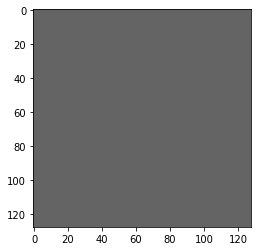

In [ ]:
print(outputs[0].cpu().detach().shape)
plt.imshow(((outputs[0].cpu().detach().view(128,128,3).numpy())*100).astype(np.uint8))


In [ ]:
test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features.cuda()
        test_examples = batch_features.view(-1, 128*128*3).cuda()
        reconstruction = model(batch_features).cpu()
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


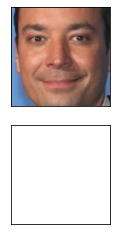

In [ ]:
with torch.no_grad():
    number = 1
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow((test_examples[index].cpu().detach().numpy().reshape(128, 128, 3)*(255)).astype(np.uint8))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(((reconstruction[index].numpy().reshape(128, 128,3))*255).astype(np.uint8))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()